# Composition of GP

## Init

In [31]:
import shutil
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import torch
import gpytorch
import jax
import jax.random as jr
import jax.numpy as jnp
import gpjax as gpx
import os
from movement_primitives.data import generate_1d_trajectory_distribution

In [2]:
def clean_legend(ax):
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles, strict=False))
    ax.legend(by_label.values(), by_label.keys())
    return ax

In [3]:
USETEX = bool(shutil.which("latex"))
mpl.rcParams["text.usetex"] = USETEX
if USETEX:
    mpl.rcParams["font.family"] = ["serif"]
    # mpl.rcParams["pgf.texsystem"] = "pdflatex"
    # mpl.rcParams["pgf.preamble"] = "\n".join([
    #      # r"\usepackage[utf8x]{inputenc}",
    #      # r"\usepackage[T1]{fontenc}",
    #      r"\usepackage[default]{gfsbodoni}",
    # ])
else:
    mpl.rcParams["font.family"] = ["sans-serif"]
    mpl.rcParams["font.sans-serif"] = [
        "Fira Sans",
        "Computer Modern Sans Serif",
        "DejaVu Sans",
        "Verdana",
        "Arial",
        "Helvetica",
    ]

In [4]:
jax.config.update("jax_enable_x64", True)

# GPJax

## Dataset

In [5]:
n = 100
noise = 0.3
key = jr.key(123)
key, subkey = jr.split(key)
x = jr.uniform(key=key, minval=-3.0, maxval=3.0, shape=(n,)).reshape(-1, 1)
f = lambda x: jnp.sin(4 * x) + jnp.cos(2 * x)
signal = f(x)
y = signal + jr.normal(subkey, shape=signal.shape) * noise
D = gpx.Dataset(X=x, y=y)

xtest = jnp.linspace(-3.5, 3.5, 500).reshape(-1, 1)
ytest = f(xtest)

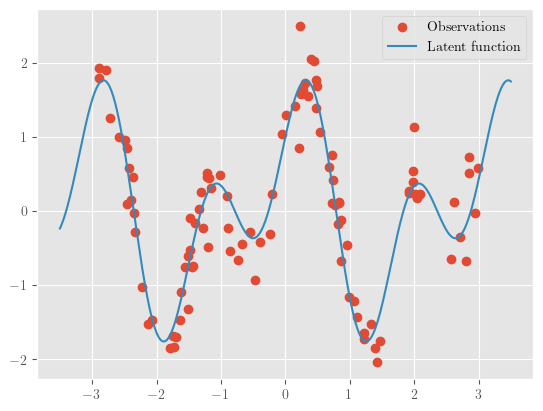

In [25]:
with mpl.style.context("ggplot"):
    cols = mpl.rcParams["axes.prop_cycle"].by_key()["color"]
    fig, ax = plt.subplots()
    ax.plot(x, y, "o", label="Observations", color=cols[0])
    ax.plot(xtest, ytest, label="Latent function", color=cols[1])
    ax.legend(loc="best")
    plt.show()

## Defining the prior

In [7]:
kernel = gpx.kernels.RBF()  # 1-dimensional input
meanf = gpx.mean_functions.Zero()
prior = gpx.gps.Prior(mean_function=meanf, kernel=kernel)

In [8]:
prior_dist = prior.predict(xtest)

prior_mean = prior_dist.mean
prior_std = prior_dist.variance
samples = prior_dist.sample(key=key, sample_shape=(20,))

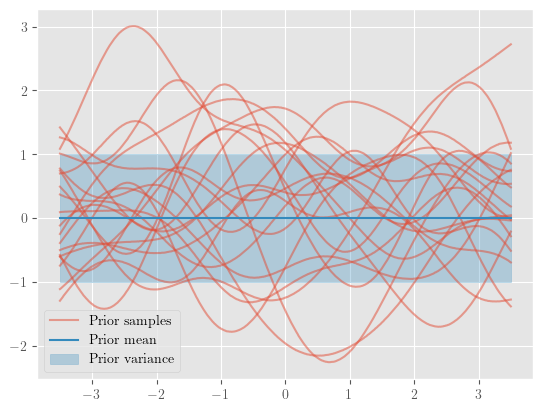

In [26]:
with mpl.style.context("ggplot"):
    fig, ax = plt.subplots()
    ax.plot(xtest, samples.T, alpha=0.5, color=cols[0], label="Prior samples")
    ax.plot(xtest, prior_mean, color=cols[1], label="Prior mean")
    ax.fill_between(
        xtest.flatten(),
        prior_mean - prior_std,
        prior_mean + prior_std,
        alpha=0.3,
        color=cols[1],
        label="Prior variance",
    )
    ax.legend(loc="best")
    ax = clean_legend(ax)
    plt.show()

## Constructing the posterior

In [10]:
likelihood = gpx.likelihoods.Gaussian(num_datapoints=D.n)

In [11]:
posterior = prior * likelihood

## Parameter state

In [12]:
opt_posterior, history = gpx.fit_scipy(
    model=posterior,
    # we use the negative mll as we are minimising
    objective=lambda p, d: -gpx.objectives.conjugate_mll(p, d),
    train_data=D,
)

print(-gpx.objectives.conjugate_mll(opt_posterior, D))

Optimization terminated successfully.
         Current function value: 55.469226
         Iterations: 12
         Function evaluations: 19
         Gradient evaluations: 19
55.46922647118369


## Prediction

In [13]:
latent_dist = opt_posterior.predict(xtest, train_data=D)
predictive_dist = opt_posterior.likelihood(latent_dist)

predictive_mean = predictive_dist.mean
predictive_std = jnp.sqrt(predictive_dist.variance)

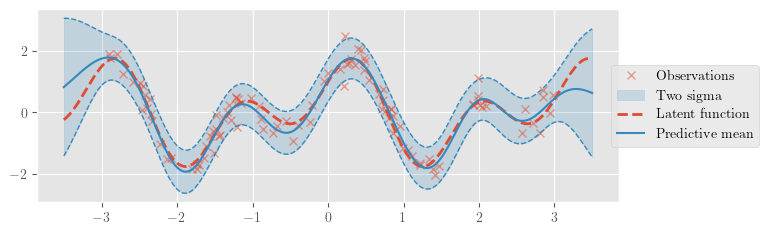

In [27]:
with mpl.style.context("ggplot"):
    fig, ax = plt.subplots(figsize=(7.5, 2.5))
    ax.plot(x, y, "x", label="Observations", color=cols[0], alpha=0.5)
    ax.fill_between(
        xtest.squeeze(),
        predictive_mean - 2 * predictive_std,
        predictive_mean + 2 * predictive_std,
        alpha=0.2,
        label="Two sigma",
        color=cols[1],
    )
    ax.plot(
        xtest,
        predictive_mean - 2 * predictive_std,
        linestyle="--",
        linewidth=1,
        color=cols[1],
    )
    ax.plot(
        xtest,
        predictive_mean + 2 * predictive_std,
        linestyle="--",
        linewidth=1,
        color=cols[1],
    )
    ax.plot(
        xtest, ytest, label="Latent function", color=cols[0], linestyle="--", linewidth=2
    )
    ax.plot(xtest, predictive_mean, label="Predictive mean", color=cols[1])
    ax.legend(loc="center left", bbox_to_anchor=(0.975, 0.5))
    plt.show()

# GPyTorch

## Set up training data

In [15]:
# Training data is 100 points in [0,1] inclusive regularly spaced
train_x = torch.linspace(0, 1, 100)
# True function is sin(2*pi*x) with Gaussian noise
train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * math.sqrt(0.04)

## The GP Model

In [16]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

## Training the model

In [17]:
# this is for running the notebook in our testing framework
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 50


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/50 - Loss: 0.956   lengthscale: 0.693   noise: 0.693
Iter 2/50 - Loss: 0.925   lengthscale: 0.644   noise: 0.644
Iter 3/50 - Loss: 0.891   lengthscale: 0.598   noise: 0.598
Iter 4/50 - Loss: 0.853   lengthscale: 0.555   noise: 0.554
Iter 5/50 - Loss: 0.810   lengthscale: 0.514   noise: 0.513
Iter 6/50 - Loss: 0.762   lengthscale: 0.475   noise: 0.474
Iter 7/50 - Loss: 0.710   lengthscale: 0.439   noise: 0.437
Iter 8/50 - Loss: 0.657   lengthscale: 0.404   noise: 0.402
Iter 9/50 - Loss: 0.607   lengthscale: 0.372   noise: 0.369
Iter 10/50 - Loss: 0.562   lengthscale: 0.342   noise: 0.339
Iter 11/50 - Loss: 0.521   lengthscale: 0.315   noise: 0.310
Iter 12/50 - Loss: 0.485   lengthscale: 0.292   noise: 0.284
Iter 13/50 - Loss: 0.450   lengthscale: 0.272   noise: 0.259
Iter 14/50 - Loss: 0.418   lengthscale: 0.255   noise: 0.236
Iter 15/50 - Loss: 0.385   lengthscale: 0.242   noise: 0.215
Iter 16/50 - Loss: 0.354   lengthscale: 0.231   noise: 0.196
Iter 17/50 - Loss: 0.323   length

## Make predictions with the model

In [18]:
# f_preds = model(test_x)
# y_preds = likelihood(model(test_x))

# f_mean = f_preds.mean
# f_var = f_preds.variance
# f_covar = f_preds.covariance_matrix
# f_samples = f_preds.sample(sample_shape=torch.Size(1000,))

In [19]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    observed_pred = likelihood(model(test_x))

## Plot the model fit

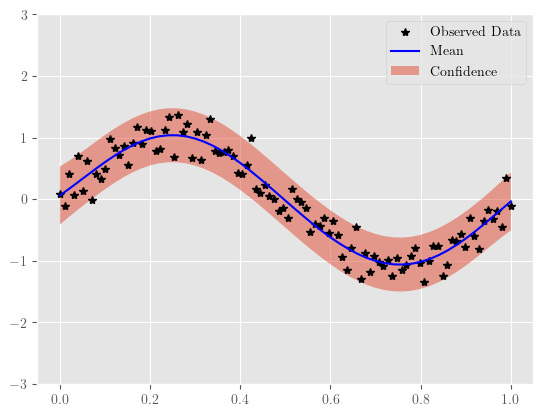

In [28]:
with torch.no_grad():
    with mpl.style.context("ggplot"):
        # Initialize plot
        f, ax = plt.subplots(1, 1)#, figsize=(4, 3))
    
        # Get upper and lower confidence bounds
        lower, upper = observed_pred.confidence_region()
        # Plot training data as black stars
        ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
        # Plot predictive means as blue line
        ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
        # Shade between the lower and upper confidence bounds
        ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
        ax.set_ylim([-3, 3])
        ax.legend(['Observed Data', 'Mean', 'Confidence'])
        plt.show()

In [32]:
n_demos = 500
z_steps = 100
z, Y = generate_1d_trajectory_distribution(n_demos, z_steps, initial_offset_range=3.0, final_offset_range=1,
        noise_per_step_range=20.0, random_state=np.random.RandomState(0))
Y = Y.squeeze()
Y.shape

(500, 100)

In [33]:
with mpl.style.context("ggplot_perso.mplstyle"):
    cmap = mpl.colormaps["tab10"].colors
    fig, ax = plt.subplots()
    for demo in range(n_demos):
        ax.plot(T1, Y1[demo, :, 0], c=cmap[0])
        ax.plot(T2, Y2[demo, :, 0], c=cmap[1])
        ax.plot(T3, Y3[demo, :, 0], c=cmap[2])
    plt.show()

NameError: name 'T1' is not defined